In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd 'drive/My Drive/Projet Challenge Oze'

/content/drive/My Drive/Projet Challenge Oze


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

from src.dataset import OzeDataset, OzeEvaluationDataset

In [0]:
BATCH_SIZE = 64
NUM_WORKERS = 4
LR = 1e-2
EPOCHS = 15

In [0]:
dataloader = DataLoader(OzeDataset(dataset_x_path="data/x_train.csv", 
                                   dataset_y_path="data/y_train.csv", 
                                   labels_path="data/labels.json",
                                   normalize=True,
                                   add_time=True),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS)

m, M = dataloader.dataset.m, dataloader.dataset.M

In [0]:
from src.model import ClassicCONV1D
method = 'ClassicCONV1D'
net = ClassicCONV1D()

[Epoch   1/15]:   0%|          | 0/7500 [00:00<?, ?it/s]

cuda:0
ClassicCONV1D(
  (tranpose): Tranpose()
  (conv1): Sequential(
    (0): Conv1d(38, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(12,), stride=(1,), padding=(11,), dilation=(2,))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (features): Sequential(
    (0): Tranpose()
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (activation): LeakyReLU(negative_slope=0.01)
  (linear2): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): Sigmoid()
  )
)


[Epoch   1/15]: 7552it [00:03, 2420.13it/s, loss=0.016]
[Epoch   2/15]: 7552it [00:03, 2500.56it/s, loss=0.00419]                          
[Epoch   3/15]: 7552it [00:03, 2464.36it/s, loss=0.00298]                          
[Epoch   4/15]: 7552it [00:03, 2448.62it/s, loss=0.00268]                          
[Epoch   5/15]: 7552it [00:03, 2459.60it/s, loss=0.00235]                          
[Epoch   6/15]: 7552it [00:03, 2458.86it/s, loss=0.00221]                          
[Epoch   7/15]: 7552it [00:03, 2449.15it/s, loss=0.0022]
[Epoch   8/15]: 7552it [00:03, 2486.09it/s, loss=0.00213]                          
[Epoch   9/15]: 7552it [00:03, 2469.13it/s, loss=0.00202]
[Epoch  10/15]: 7552it [00:03, 2432.07it/s, loss=0.00208]                          
[Epoch  11/15]: 7552it [00:02, 2535.72it/s, loss=0.00185]                          
[Epoch  12/15]: 7552it [00:03, 2469.79it/s, loss=0.00183]                          
[Epoch  13/15]: 7552it [00:03, 2433.83it/s, loss=0.00182]                

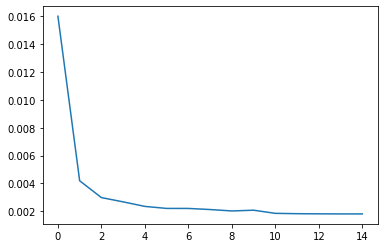

Loss: 0.001812


In [13]:
# Predictions to use:
indices = [0,1,2,3,4,5,6,7]

# Full Model:
from src.train import train
indices = [0,1,2,3,4,5,6,7]
optimizer = optim.Adam(net.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=10, 
                                            gamma=0.1, 
                                            last_epoch=-1)
loss_function = nn.MSELoss()

hist_loss = train(EPOCHS, 
                  indices, 
                  net, 
                  dataloader, 
                  optimizer, 
                  scheduler, 
                  loss_function)

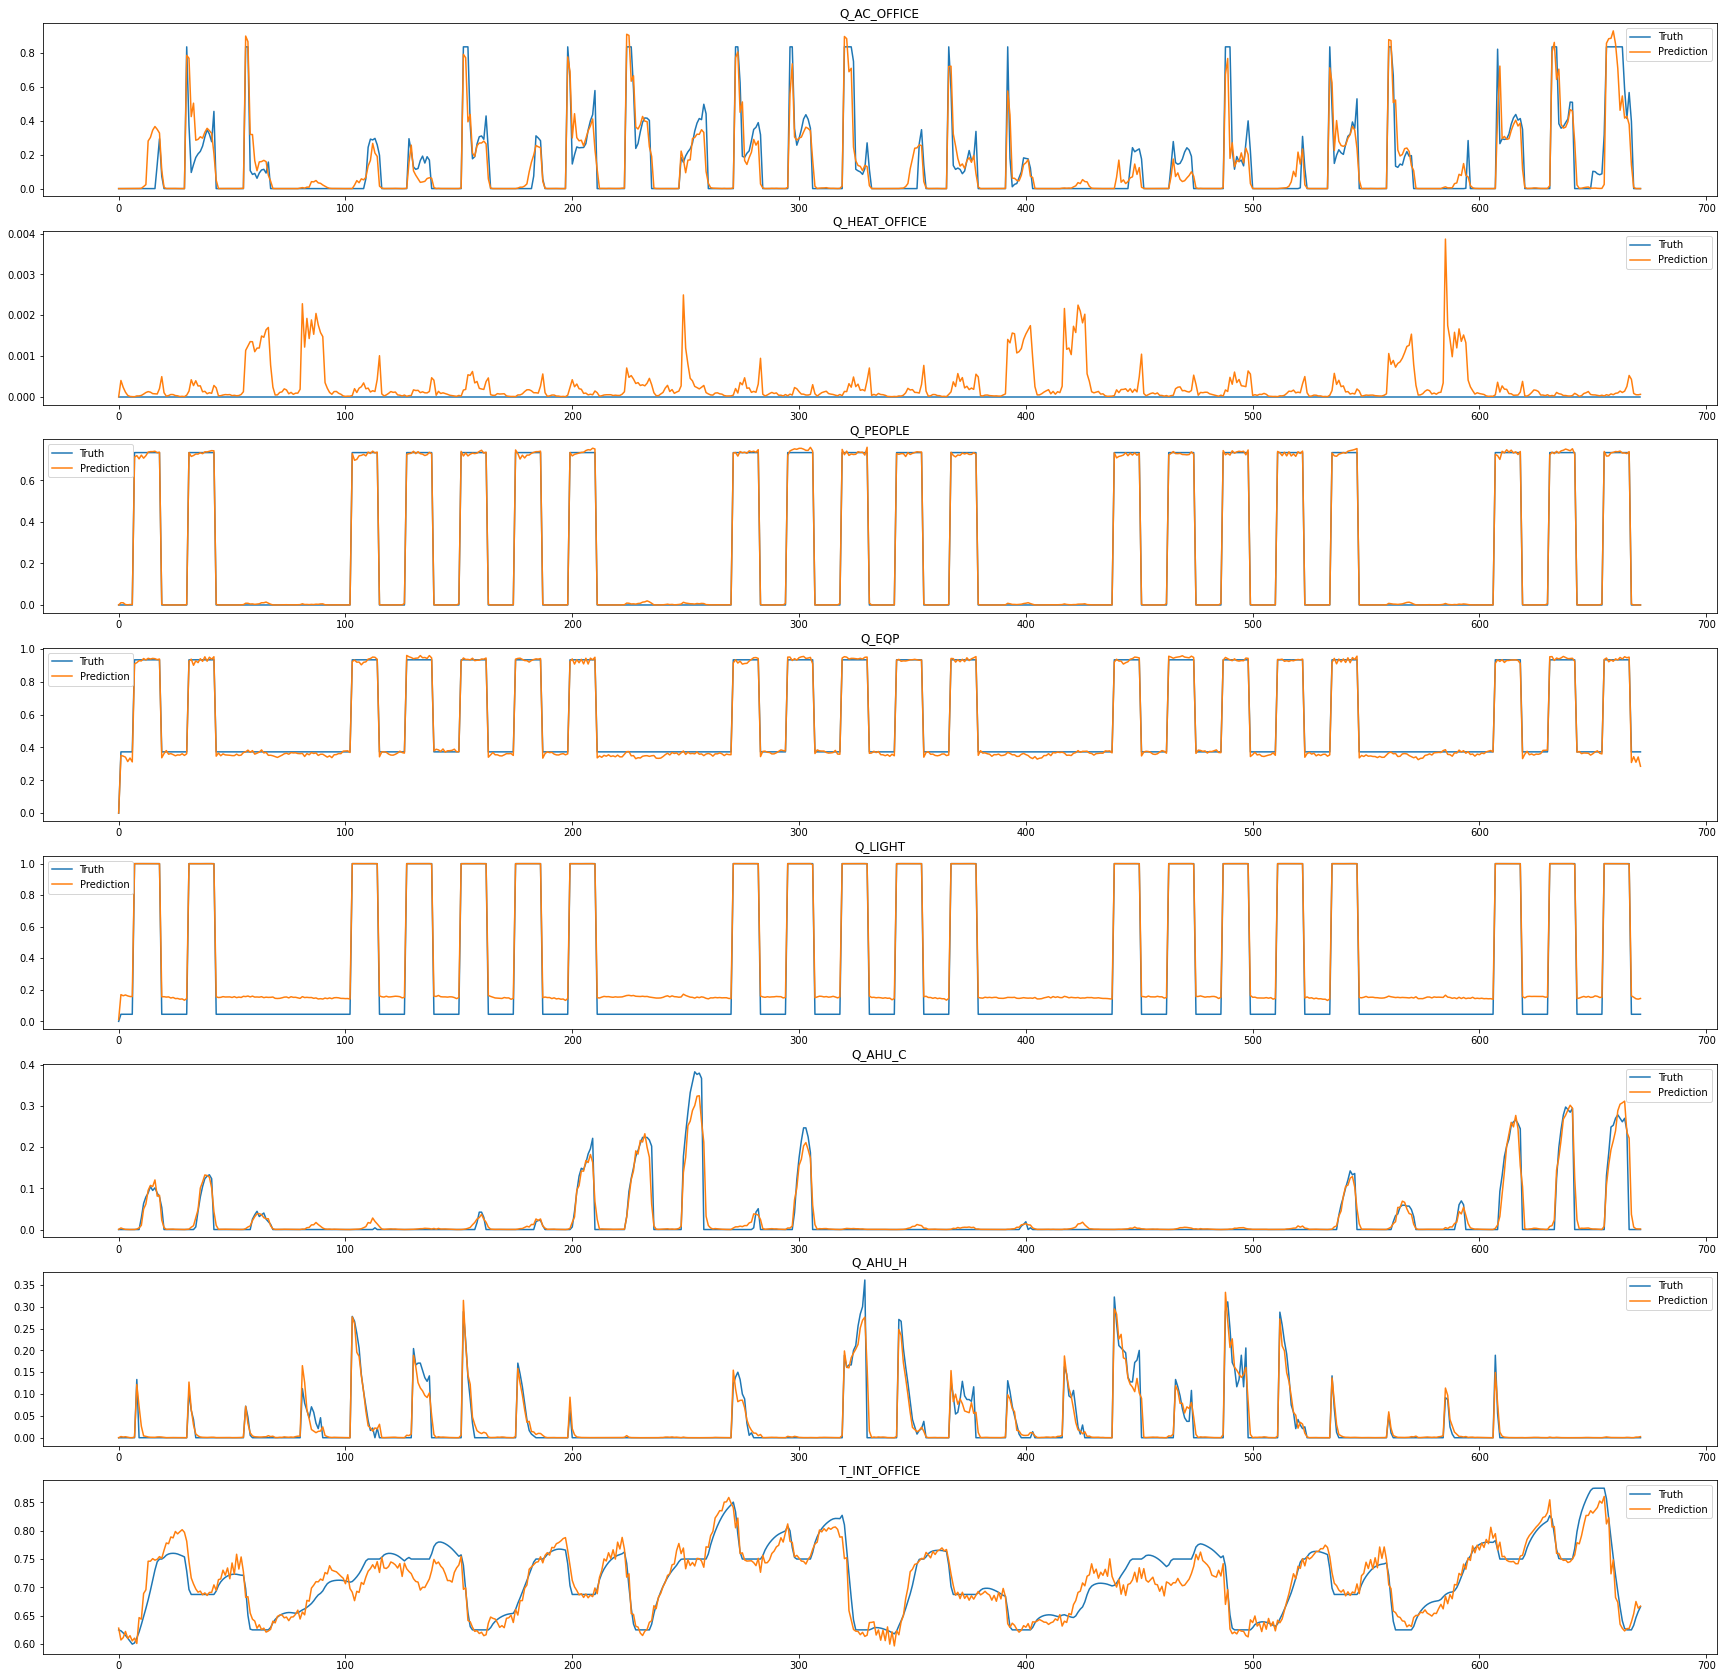

In [16]:
# Select training example
idx = np.random.randint(0, len(dataloader.dataset))
x, y = dataloader.dataset[idx]

net.to('cpu')
# Run predictions
with torch.no_grad():
    x = torch.Tensor(x[np.newaxis, :, :])
    netout = net(x)

y = np.take(y, indices, axis=1)
plt.figure(figsize=(30, 30))
n = len(indices)
for idx_output_var in range(n):
    # Select real temperature
    y_true = y[:, idx_output_var]

    y_pred = netout[0, :, idx_output_var]
    y_pred = y_pred.numpy()

    plt.subplot(n, 1, idx_output_var+1)
    
    plt.plot(y_true, label="Truth")
    plt.plot(y_pred, label="Prediction")
    plt.title(dataloader.dataset.labels["X"][indices[idx_output_var]])
    plt.legend()
plt.show()

In [0]:
dataset_eval = OzeEvaluationDataset(dataset_x_path="data/x_test.csv", 
                                    labels_path="data/labels.json",
                                    add_time=True)
m_test = len(dataset_eval)

In [0]:
# m_test = 500
# K = 672
predictions = np.zeros((m_test, K, 8))

with torch.no_grad():
    for idx, line in tqdm(enumerate(dataset_eval), total=m_test):
        # Run prediction
        netout = net(torch.Tensor(line[np.newaxis, :, :]).to(device)).cpu().numpy()
        # De-normalize output
        output = netout  * (M - m + np.finfo(float).eps) + m
        predictions[idx] = output

In [0]:
lines_output = np.transpose(predictions, axes=(0,2,1))
lines_output[:,1,:] = np.zeros((500,K))
lines_output = lines_output.reshape(500,-1)
csv_header = [f"{var_name}_{k}" for var_name in dataset_eval.labels['X'] for k in range(K)]

dataframe_index = pd.DataFrame(np.arange(7500,8000).reshape(-1,1), columns=['index'])
dataframe_output = pd.DataFrame(lines_output, columns=csv_header)
data = data = pd.concat([dataframe_index, dataframe_output], axis = 1)
# Verify first columns is Index.astype(int) and other columns are fine
data.head()

In [0]:
plt.figure(figsize=(30, 30))
n = 8
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.plot(data.iloc[0,672*i+1:672*i+672].tolist())
plt.show()

In [0]:
# if everything is okay, you can save the god damn answer !
data.to_csv('data/y_GRUb_time.csv', index=False)